In [134]:
# Helpers
import pickle
import numpy as np
import time

# DB 
import psycopg2
from django.conf import settings

# Learning
from fdtf import feedback_driven_tensor_factorization
from sklearn.cluster import AgglomerativeClustering

# Evaluation
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from skbio.stats.distance import anosim
from skbio import DistanceMatrix

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                                  password = settings.DATABASES["default"]["PASSWORD"],
                                  host = settings.DATABASES["default"]["HOST"],
                                  port = settings.DATABASES["default"]["PORT"],
                                  database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

In [136]:
%%time
query_test = """select experiment_id, sp, x, sp_hat from edm2020_2020_02_19 
where method='fdtf' and concepts >=3 and concepts <= 5 and mu = '0.1' and attempts_train = 20"""

cursor.execute(query_test)
rows = cursor.fetchall()

CPU times: user 2.6 s, sys: 269 ms, total: 2.86 s
Wall time: 31.7 s


Youden's optimum threshold: 0.30
Proportional: 0.24
Acc: 0.66
F-Score: 0.20
Train 1: 453
Train 1 Pred: 452
LL: 0.62
[[1290  362]
 [ 363   90]]


<Figure size 432x288 with 0 Axes>

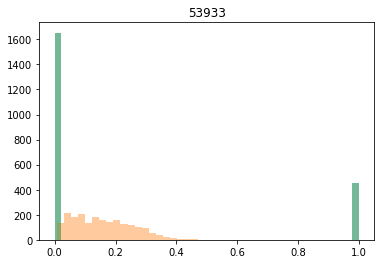

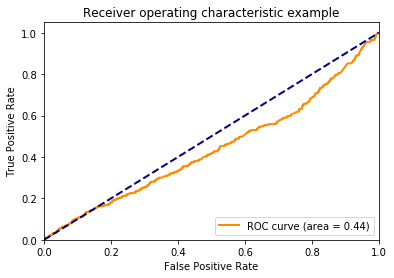

Youden's optimum threshold: 0.47
Proportional: 0.18
Acc: 0.65
F-Score: 0.17
Train 1: 450
Train 1 Pred: 449
LL: 0.67
[[1290  371]
 [ 372   78]]


<Figure size 432x288 with 0 Axes>

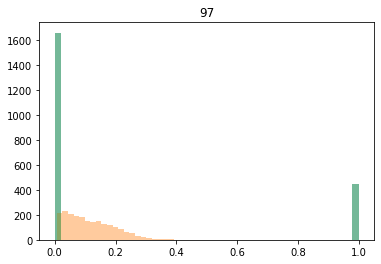

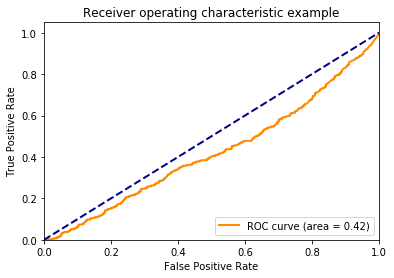

Youden's optimum threshold: 0.31
Proportional: 0.16
Acc: 0.65
F-Score: 0.18
Train 1: 450
Train 1 Pred: 449
LL: 0.67
[[1291  370]
 [ 371   79]]


<Figure size 432x288 with 0 Axes>

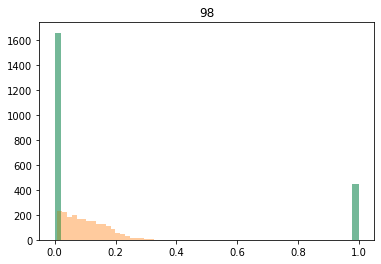

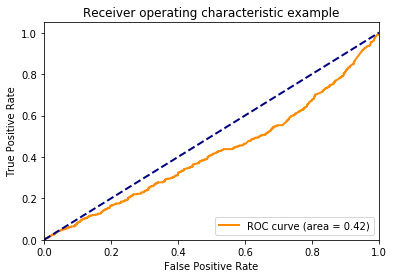

Youden's optimum threshold: 0.25
Proportional: 0.16
Acc: 0.66
F-Score: 0.20
Train 1: 453
Train 1 Pred: 452
LL: 0.66
[[1290  362]
 [ 363   90]]


<Figure size 432x288 with 0 Axes>

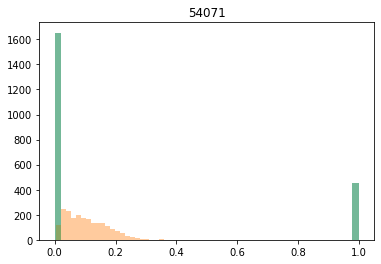

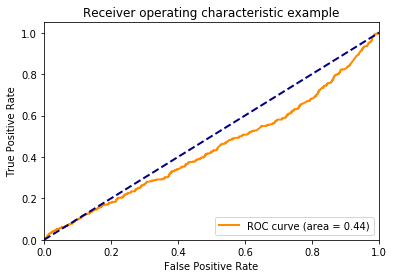

Youden's optimum threshold: 0.55
Proportional: 0.26
Acc: 0.64
F-Score: 0.16
Train 1: 450
Train 1 Pred: 449
LL: 0.64
[[1286  375]
 [ 376   74]]


<Figure size 432x288 with 0 Axes>

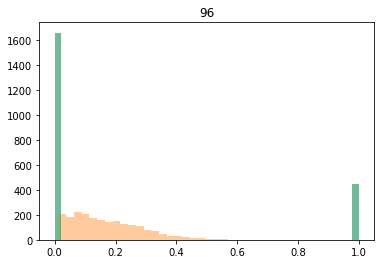

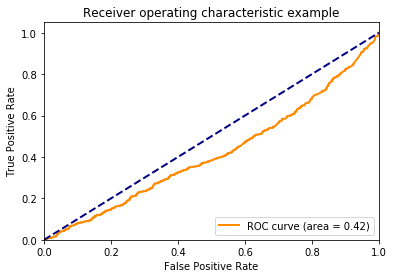

Youden's optimum threshold: 0.34
Proportional: 0.20
Acc: 0.65
F-Score: 0.19
Train 1: 453
Train 1 Pred: 452
LL: 0.64
[[1287  365]
 [ 366   87]]


<Figure size 432x288 with 0 Axes>

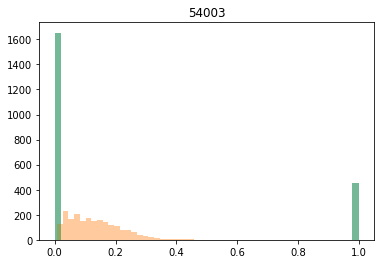

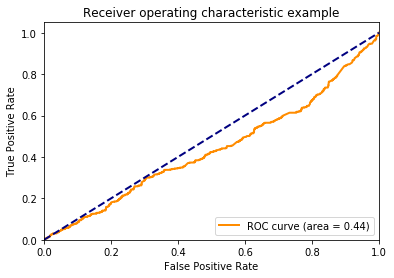

Youden's optimum threshold: 0.28
Proportional: 0.16
Acc: 0.65
F-Score: 0.19
Train 1: 456
Train 1 Pred: 455
LL: 0.68
[[1266  367]
 [ 368   88]]


<Figure size 432x288 with 0 Axes>

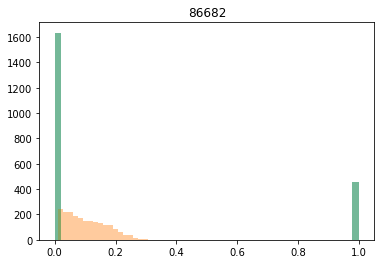

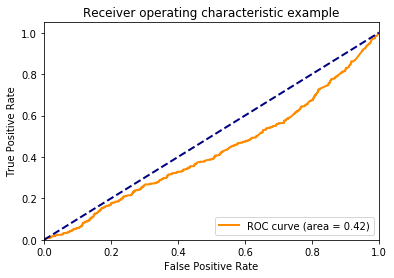

Youden's optimum threshold: 0.29
Proportional: 0.24
Acc: 0.66
F-Score: 0.21
Train 1: 453
Train 1 Pred: 452
LL: 0.62
[[1296  356]
 [ 357   96]]


<Figure size 432x288 with 0 Axes>

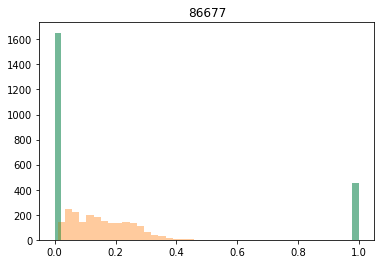

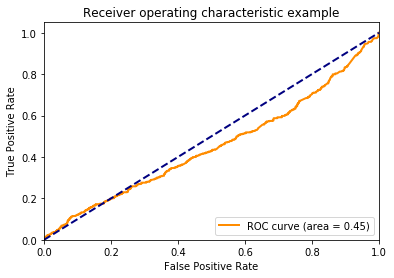

Youden's optimum threshold: 0.23
Proportional: 0.18
Acc: 0.66
F-Score: 0.21
Train 1: 453
Train 1 Pred: 452
LL: 0.65
[[1293  359]
 [ 360   93]]


<Figure size 432x288 with 0 Axes>

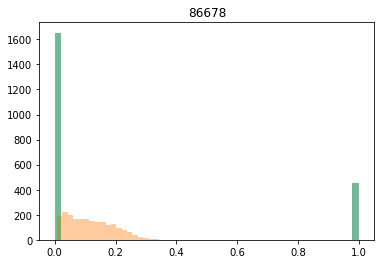

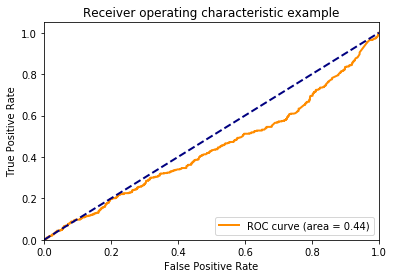

Youden's optimum threshold: 0.47
Proportional: 0.24
Acc: 0.64
F-Score: 0.18
Train 1: 456
Train 1 Pred: 455
LL: 0.64
[[1261  372]
 [ 373   83]]


<Figure size 432x288 with 0 Axes>

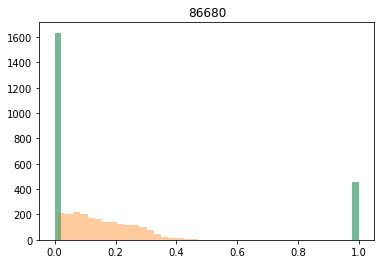

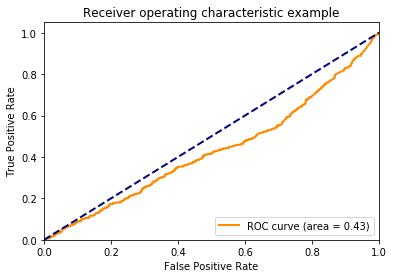

Youden's optimum threshold: 1.50
Proportional: 0.19
Acc: 0.65
F-Score: 0.20
Train 1: 456
Train 1 Pred: 455
LL: 0.66
[[1269  364]
 [ 365   91]]


<Figure size 432x288 with 0 Axes>

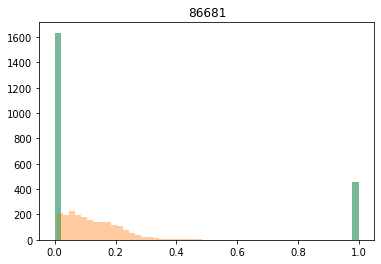

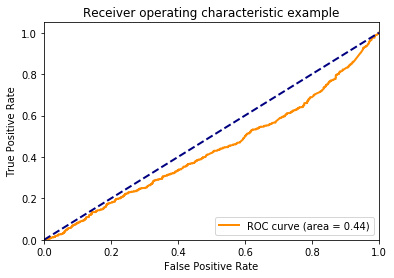

In [137]:
experiments_train = []
for row in rows:
    exp_id, sp, X, sp_hat = row
    X = np.asarray(X)
    sp = np.asarray(sp)
    sp_hat = np.asarray(sp_hat)
    
    attempts_per_question = X.sum(axis=0).sum(axis=1)
    del_questions = [idx for idx,value in enumerate(attempts_per_question) if value < 3]
    X = np.delete(X, del_questions, axis=1)
    
    # Get train predicted values
    plt.figure()
    y = sp[np.where(X == 1)]
    y_pred = sp_hat[np.where(X == 1)]
    
    # Proportional
    y_pred_sorted =y_pred.copy()
    y_pred_sorted.sort()
    train_1 = np.where(y == 1)[0].shape[0]
    
    # AUC and threshold
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=1)
    auc_score = auc(fpr, tpr)
    J_stats = tpr - fpr
    J_opt_thresholds = thresholds[np.argmax(J_stats)]
    print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)
    plt.figure()
    
    y_pred_binary = np.where(np.asarray(y_pred) > y_pred_sorted[-train_1], 1, 0)
#     y_pred_binary = np.where(y_pred > J_opt_thresholds, 1, 0)
    acc = np.logical_not(np.logical_xor(y, y_pred_binary)).sum()/len(y)
    f1 = f1_score(y, y_pred_binary)
    train_pred_1 = np.where(y_pred_binary == 1)[0].shape[0]
    y_pred_all = np.zeros((y.shape[0], 2))
    y_pred_all[:,0] = 1-y_pred
    y_pred_all[:,1] = y_pred
    ll = -np.mean(np.log(y_pred_all[range(y.shape[0]), y.astype(int)]))
    
    print("Proportional: %.2f" % y_pred_sorted[-train_1])
    print("Acc: %.2f" % acc)
    print("F-Score: %.2f" % f1)
    print("Train 1: %d" % train_1)
    print("Train 1 Pred: %d" % train_pred_1)
    print("LL: %.2f" % ll)
    print(confusion_matrix(y,y_pred_binary))
        
    sns.distplot(y, kde=False)
    sns.distplot(y_pred, kde=False)
    sns.distplot(y_pred_binary, kde=False)
    plt.title("%d" % exp_id)
    plt.show()
    
     # Calculate AUC and threshold to binarize prediction
 
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    experiments_train.append(exp_id)

In [138]:
tuple(experiments_train)

(53933, 97, 98, 54071, 96, 54003, 86682, 86677, 86678, 86680, 86681)

In [139]:
# experiments_train = (
#     # Best FDTF train_rmse 
#     26030, 
# #     277, 
#     # Best NMF train_rmse with 1 attempt (so we can calculate accuracy) and overall
# #     52473,
# #     52126
# )
# experiments_q_matrix = (
#     # Best FDTF Q-Matrix rmse
# #     274,
# #     17805,
#     # Best NMF Q-Matrix rmse,
# #     56936,
# #     56954
# )

# experiments_test = (
#     # Best FDTF test rmse
# #     17,
#     #16
#     # Best NMF test rmse,

#     )

In [140]:
query = """select q_matrix, q_matrix_hat, concepts, method, experiment_id 
from EDM2020_2020_02_19 where experiment_id in %s """
# or experiment_id in %s or experiment_id in %s"""
# query = """select q_matrix, q_matrix_hat, q_matrix_rmse from edm2020_2020_02_19 
# where method='fdtf' order by q_matrix_rmse"""

query = cursor.mogrify(query, (tuple(experiments_train),))# experiments_q_matrix, experiments_test))
cursor.execute(query)
response = cursor.fetchall()

In [141]:
data = {}
for idx, row in enumerate(response):
    data[idx] = {}
    data[idx]['exp_id'] = row[-1]
    data[idx]['method'] = row[-2]
    if data[idx]['exp_id'] in experiments_train:
        data[idx]['type'] = 'train_rmse'
    elif data[idx]['exp_id'] in experiments_test:
        data[idx]['type'] = 'test_rmse'
    else:
        data[idx]['type'] = 'q_matrix_rmse'
    data[idx]['concepts'] = row[2]
    print("%d - %s - %s" % (data[idx]['exp_id'], data[idx]['method'], data[idx]['type']))
    data[idx]['q_matrix'] = np.asarray(row[0])
    q_matrix = data[idx]['q_matrix']
#     row_sums = data[idx]['q_matrix'].sum(axis=0)
#     data[idx]['q_matrix_norm'] = data[idx]['q_matrix'] / row_sums
    data[idx]['q_matrix_hat'] = np.asarray(row[1])
    q_matrix_hat = data[idx]['q_matrix_hat']
#     row_sums = data[idx]['q_matrix_hat'].sum(axis=0)
#     data[idx]['q_matrix_norm_hat'] = data[idx]['q_matrix_hat'] / row_sums
    data[idx]['question_similarity'] = cosine_similarity(q_matrix.T)
    data[idx]['question_distance'] = cosine_distances(q_matrix.T)
    data[idx]['question_hat_similarity'] = cosine_similarity(q_matrix_hat.T)
    data[idx]['question_hat_distance'] = cosine_distances(q_matrix_hat.T)
    error = data[idx]['question_similarity'] - data[idx]['question_hat_similarity']
    data[idx]['error'] = np.sqrt(np.sum(np.power(error,2)))
    data[idx]['rmse'] = np.sqrt(np.mean(np.power(error,2)))
    qs = data[idx]['question_similarity']
    qs_hat = data[idx]['question_hat_similarity']
    data[idx]['cmd'] = 1-np.trace(np.dot(qs,
                                         qs_hat))/(np.linalg.norm(qs)*np.linalg.norm(qs_hat))
    print(data[idx]['cmd'])

96 - fdtf - train_rmse


ValueError: operands could not be broadcast together with shapes (48,48) (47,47) 

In [127]:
import pandas as pd

In [128]:
df = pd.DataFrame.from_dict(data, orient='index').set_index('exp_id')
df = df[['method', 'concepts', 'type', 'error', 'rmse', 'cmd']]

In [132]:
df.mean()

concepts     6.500000
error       18.601169
rmse         0.387524
cmd          0.290474
dtype: float64

In [133]:
df.std()

concepts    1.737021
error       1.338010
rmse        0.027875
cmd         0.016317
dtype: float64

In [131]:
df.groupby('concepts').mean()

,error,rmse,cmd
concepts,,,
4,20.657401,0.430363,0.292713
5,19.790944,0.412311,0.302705
6,17.941302,0.373777,0.279604
7,18.282302,0.380881,0.293311
8,17.567937,0.365999,0.285753
9,17.367130,0.361815,0.288760


In [130]:
from sklearn.cluster import AgglomerativeClustering

In [98]:
for idx in range(len(data)):
    print("%d - %d - %s - %s - %d" % (idx, data[idx]['exp_id'], data[idx]['method'], 
                                      data[idx]['type'], data[idx]['concepts']))
    print(data[idx]['cmd'])
    models = []
    dm = DistanceMatrix(data[idx]['question_distance'])
    stats_list = []
    p_values = []
    for i in range(2, 20):
        model = AgglomerativeClustering(n_clusters=i, 
                                        affinity='cosine',
                                        linkage='single').fit(data[idx]['q_matrix_hat'].T)
    #     model = SpectralClustering(n_clusters=i, n_init=100, affinity='precomputed').fit(
    #         data[idx]['question_hat_similarity'].T)
    #     model = SpectralClustering(n_clusters=i, n_init=100, affinity='rbf').fit(
    #         data[idx]['q_matrix_hat'].T)
    #     model = KMeans(n_clusters=i, n_init=100).fit(data[idx]['q_matrix_hat'].T)
        models.append(model)
        stats = anosim(dm, model.labels_, permutations=9999)
        stats_list.append(stats['test statistic'])
        p_values.append(stats['p-value'])
    print(np.where(np.asarray(p_values) < 0.1)[0]+1)
    print(np.asarray(stats_list)[np.where(np.asarray(p_values) < 0.1)])
    print()

0 - 192 - fdtf - train_rmse - 9
0.2600060823427962
[]
[]

1 - 60717 - fdtf - train_rmse - 9
0.28044941155493397
[ 4  5  6  7  8 17 18]
[0.11952686 0.11992112 0.17452467 0.14056899 0.10168658 0.10492992
 0.10520666]

2 - 66724 - fdtf - train_rmse - 9
0.28882833524827256
[ 2  5  6  7  8  9 10 11 12 13 16 17]
[0.23306841 0.22234967 0.12681935 0.14939854 0.14647422 0.13944633
 0.14408441 0.10683973 0.10469321 0.10757292 0.09776669 0.09911413]

3 - 69034 - fdtf - train_rmse - 9
0.2931529963333459
[1]
[0.43192867]

4 - 69050 - fdtf - train_rmse - 9
0.3213645034110507
[]
[]



In [378]:
stats_list

[0.031143933460146832,
 -0.07877606756022211,
 -0.04087854087854093,
 -0.03789377766206707,
 -0.04706930746140639,
 0.039631190169772366,
 0.04229587095851908,
 0.0758107956458309,
 0.07643988701952605,
 0.04786588582884877,
 0.038074348649297304,
 0.05036541643684499,
 0.05218367418528789,
 0.019998600097993036,
 0.038588804980688216,
 0.035056068484912876,
 0.026571418228330694,
 0.005022954361328564]

In [351]:
p_values

[0.12,
 0.42,
 0.28,
 0.56,
 0.73,
 0.42,
 0.63,
 0.59,
 0.42,
 0.72,
 0.74,
 0.86,
 0.59,
 0.6,
 0.67,
 0.68,
 0.52,
 0.51]

### Organizing data

In [3]:
def add_to_tensor(data, tensor, X, filter_attempt=False):
    for item in data:
        s_idx, q_idx, a_idx, outcome = item

        # If attempt is over max value, ignore it
        if filter_attempt and a_idx >= filter_attempt:
            continue

        tensor[s_idx, q_idx, a_idx] = outcome
        X[s_idx, q_idx, a_idx] = 1
        
    tensor[np.where(X[:,:] == 0)] = None
    return tensor, X
    
def transform_data(data, n_attempts):
    N_STUDENTS = len(data['users_idx'])
    N_QUESTIONS = len(data['questions_idx'])
    
    student_performance = np.zeros((N_STUDENTS, N_QUESTIONS, n_attempts))
    X = np.zeros(student_performance.shape)

    student_performance, X = add_to_tensor(data['train_set'], 
                                           student_performance, 
                                           X, filter_attempt=n_attempts)
    
    
    max_attempt = np.max(data['test_set'][:,2])+1
    student_performance_test = np.zeros((N_STUDENTS, N_QUESTIONS, max_attempt))
    X_test = np.zeros(student_performance_test.shape)
    student_performance_test, X_test = add_to_tensor(data['test_set'], 
                                                     student_performance_test, 
                                                     X_test)
    return student_performance, X, student_performance_test, X_test

Do grid search to explore parameters

In [5]:
# %%time
# mu = [0.1, 0.5, 1, 3, 10]
mu = [3]
# n_concepts = range(2, 20)
n_concepts = [14]
# attempts = [10, 20, 50, 100, 150, 200]
attempts = [10]

In [24]:
search = 1 * N_RUNS * len(attempts) * len(mu) * len(n_concepts)
search

2700

In [18]:
def run(*args):
    dataset, data, att, student_performance, X, student_performance_test, X_test, del_questions, m, concept = args
    
    # Run FDTF
    start = time.time()
    (best_student_performance_pred, best_student_knowledge, 
     best_q_matrix, best_error) = feedback_driven_tensor_factorization(
        student_performance, n_concepts=concept, init=10, max_iter=1000, mu=m)
#                     student_performance, n_concepts=concept, init=1, max_iter=3, mu=m)
    end = time.time()

    if concept == 14:
        q_matrix = np.delete(data['q_matrix'], del_questions, axis=1)
        q_matrix_error = np.sqrt(np.sum(np.power(q_matrix-best_q_matrix, 2)))
    else:
        q_matrix = data['q_matrix']
        q_matrix_error = -1

    row = {
        "dataset": "run_%d" % dataset,
        "q_matrix": q_matrix,
        "X": X,
        "sp": student_performance,
        "X_test": X_test,
        "sp_test": student_performance_test,
        "sp_hat": best_student_performance_pred,
        "sk_hat": best_student_knowledge,
        "q_matrix_hat": best_q_matrix,
        "mu": m,
        "concepts": concept,
        "attempts_train": att,
        "method": "fdtf",
        "q_matrix_error": q_matrix_error,
        "reconstruction_error": best_error,
        "train_error": 0,
        "test_error": 0,
        "seconds": end-start
    }
    
    return row

In [19]:
args = []
for restart in range(1):
    for dataset in range(N_RUNS):
        with open("%s/run_%d.pkl" % (folder, dataset), "rb") as pklfile:
            data = pickle.load(pklfile)
        for att in attempts:
            # Get train and test data in FDTF format
            student_performance, X, student_performance_test, X_test = transform_data(data, att)
            # Check if questions have minimum number of attempts
            attempts_per_question = X.sum(axis=0).sum(axis=1)
            del_questions = [idx for idx,value in enumerate(attempts_per_question) if value < 3]
            student_performance = np.delete(student_performance, del_questions, axis=1)
            
            for m in mu:
                for concept in n_concepts:                
                    args.append([dataset, 
                                data, 
                                att, 
                                student_performance, 
                                X, 
                                student_performance_test, 
                                X_test, 
                                del_questions,
                                m,
                                concept])

In [20]:
len(args)

5

In [21]:
%%time
row = run(*args[0])

CPU times: user 2min 9s, sys: 3.93 s, total: 2min 13s
Wall time: 1min 7s


In [25]:
rmse = np.sqrt(np.mean(np.power(row['q_matrix']-row['q_matrix_hat'], 2)))
rmse

0.4616764283646856